In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the dataset
import zipfile
import os
zip_file_path = "/content/drive/MyDrive/Lits_dataset_Haritha.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [ ]:
# Specify the root file path
directory_path = "/content/dataset"

In [ ]:
# Display the folder structure
for root, dirs, files in os.walk(directory_path):
    print(root, "contains", len(files), "files")

/content/dataset contains 0 files
/content/dataset/train_frames contains 0 files
/content/dataset/train_frames/train_frames contains 49842 files
/content/dataset/train_masks contains 0 files
/content/dataset/train_masks/train_masks contains 49842 files
/content/dataset/val_frames contains 0 files
/content/dataset/val_frames/val_frames contains 8796 files
/content/dataset/val_masks contains 0 files
/content/dataset/val_masks/val_masks contains 8796 files


Display One Image from Each Folder and Count Images

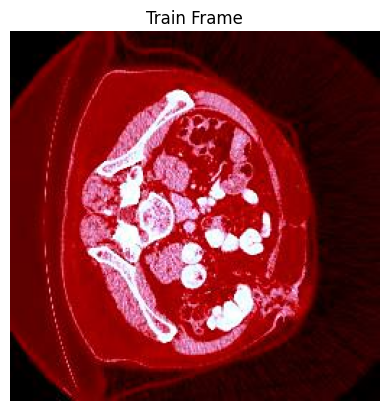

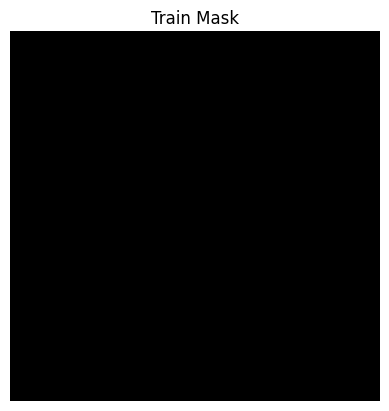

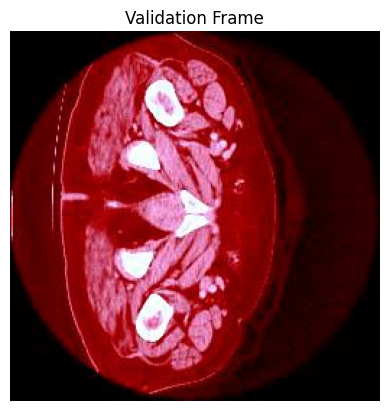

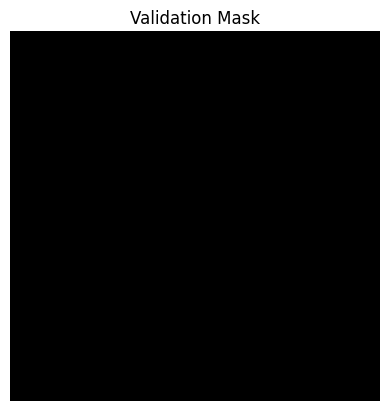

Total Train Frames: 49842
Total Train Masks: 49842
Total Validation Frames: 8796
Total Validation Masks: 8796


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Define paths for each subfolder
train_frames_path = os.path.join(directory_path, 'train_frames', 'train_frames')
train_masks_path = os.path.join(directory_path, 'train_masks', 'train_masks')
val_frames_path = os.path.join(directory_path, 'val_frames', 'val_frames')
val_masks_path = os.path.join(directory_path, 'val_masks', 'val_masks')

# Helper function to display an image
def display_image(folder_path, title):
    image_files = os.listdir(folder_path)
    image_path = os.path.join(folder_path, image_files[0])
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    return len(image_files)

# Display images and count them
train_frames_count = display_image(train_frames_path, 'Train Frame')
train_masks_count = display_image(train_masks_path, 'Train Mask')
val_frames_count = display_image(val_frames_path, 'Validation Frame')
val_masks_count = display_image(val_masks_path, 'Validation Mask')

# Print total counts
print(f"Total Train Frames: {train_frames_count}")
print(f"Total Train Masks: {train_masks_count}")
print(f"Total Validation Frames: {val_frames_count}")
print(f"Total Validation Masks: {val_masks_count}")


Data Preprocessing using data generator (Cleaning, Normalization, Resizing, Augmentation)

In [ ]:
import numpy as np
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

IMG_WIDTH = 256
IMG_HEIGHT = 256

# Directory paths
train_frames_dir = "/content/dataset/train_frames/train_frames"
train_masks_dir = "/content/dataset/train_masks/train_masks"
val_frames_dir = "/content/dataset/val_frames/val_frames"
val_masks_dir = "/content/dataset/val_masks/val_masks"

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(256, 256), augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indexes]
        batch_mask_paths = [self.mask_paths[k] for k in batch_indexes]

        images, masks = self.__data_generation(batch_image_paths, batch_mask_paths)
        return images, masks

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
      images = np.empty((self.batch_size, *self.image_size, 1))
      masks = np.empty((self.batch_size, *self.image_size, 1))

      for i, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        image = cv2.resize(image, self.image_size)
        image = image / 255.0  # Normalization

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        mask = cv2.resize(mask, self.image_size)
        mask = mask / 255.0  # Normalization
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images[i,] = np.expand_dims(image, axis=-1)  # Add channel dimension

      return images, masks

In [ ]:
# Paths to your image and mask directories
train_image_paths = sorted(glob.glob(os.path.join(train_frames_dir, "*.jpg")))
train_mask_paths = sorted(glob.glob(os.path.join(train_masks_dir, "*.jpg")))
val_image_paths = sorted(glob.glob(os.path.join(val_frames_dir, "*.jpg")))
val_mask_paths = sorted(glob.glob(os.path.join(val_masks_dir, "*.jpg")))

In [ ]:
# Create data generators
train_generator = DataGenerator(train_image_paths, train_mask_paths, batch_size=16)
val_generator = DataGenerator(val_image_paths, val_mask_paths, batch_size=16)

Model Development

U-Net Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Dropout
from tensorflow.keras.models import Model

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.2)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Dropout(0.1)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [ ]:
import tensorflow as tf

# Mixed precision policy setup
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
# Define your model
unet_model = unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()


# Data pipeline setup
def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = mask / 255.0  # Normalize

    return image, mask

def load_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = load_dataset(train_image_paths, train_mask_paths, batch_size=16)
val_dataset = load_dataset(val_image_paths, val_mask_paths, batch_size=16)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Callbacks
checkpoint_unet = tf.keras.callbacks.ModelCheckpoint('unet_model.keras', verbose=1, save_best_only=True)
early_stopping_unet = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

# Training U-Net model
history_unet = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint_unet, early_stopping_unet]
)

Epoch 1/5
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9808 - loss: nan
Epoch 1: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 1330s 344ms/step - accuracy: 0.9808 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 2/5
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9812 - loss: nan
Epoch 2: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 1012s 318ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 3/5
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9812 - loss: nan
Epoch 3: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 1039s 318ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 4/5
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9812 - loss: nan
Epoch 4: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 1071s 327ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 5/5
31

Unet++

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model

def unet_plus_plus(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.2)(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Dropout(0.1)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [ ]:
# compile
unet_pp_model = unet_plus_plus()
unet_pp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_pp_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 256)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 16, 16, 512)    │              0 │ max_pooling2d_7[0][0]  │
├──────────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#data pipeline for efficient loading.
def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = mask / 255.0  # Normalize

    return image, mask

def load_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = load_dataset(train_image_paths, train_mask_paths, batch_size=16)
val_dataset = load_dataset(val_image_paths, val_mask_paths, batch_size=16)


In [ ]:
#train the model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint_unet_pp = tf.keras.callbacks.ModelCheckpoint('unet_pp_model.keras', verbose=1, save_best_only=True)
early_stopping_unet_pp = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

# Training
history_unet_pp = unet_pp_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint_unet_pp, early_stopping_unet_pp]
)


Epoch 1/5
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9807 - loss: nan
Epoch 1: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 1022s 295ms/step - accuracy: 0.9807 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 2/5
3115/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9812 - loss: nan
Epoch 2: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 921s 287ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 3/5
3115/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9812 - loss: nan
Epoch 3: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 922s 287ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 4/5
3115/3116 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9812 - loss: nan
Epoch 4: val_loss did not improve from inf
3116/3116 ━━━━━━━━━━━━━━━━━━━━ 861s 276ms/step - accuracy: 0.9812 - loss: nan - val_accuracy: 0.9804 - val_loss: nan
Epoch 5/5
3115/

Evaluation Metrics

In [ ]:
for images, masks in val_dataset.take(1):
    print("Batch of images shape:", images.shape)
    print("Batch of masks shape:", masks.shape)

Batch of images shape: (16, 256, 256, 1)
Batch of masks shape: (16, 256, 256, 1)


In [ ]:
def evaluate_model_on_subset(model, generator, subset_size=100):
    # Fetch a subset of the validation data
    subset_generator = DataGenerator(
        image_paths=val_image_paths[:subset_size],
        mask_paths=val_mask_paths[:subset_size],
        batch_size=16
    )
    results = model.evaluate(subset_generator, verbose=1)
    return results

# Evaluate models on a subset
results_unet = evaluate_model_on_subset(unet_model, val_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 285s 46s/step - accuracy: 0.3775 - loss: 0.6944


In [ ]:
# Print the input shape expected by the model
print("Input shape of U-Net model:", unet_model.input_shape)
print("Input shape of U-Net++ model:", unet_pp_model.input_shape)


Input shape of U-Net model: (None, 256, 256, 1)
Input shape of U-Net++ model: (None, 256, 256, 1)


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, img_width=256, img_height=256):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, (img_width, img_height))
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

def load_images(image_paths, img_width=256, img_height=256):
    images = [preprocess_image(image_path, img_width, img_height) for image_path in image_paths]
    return np.array(images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


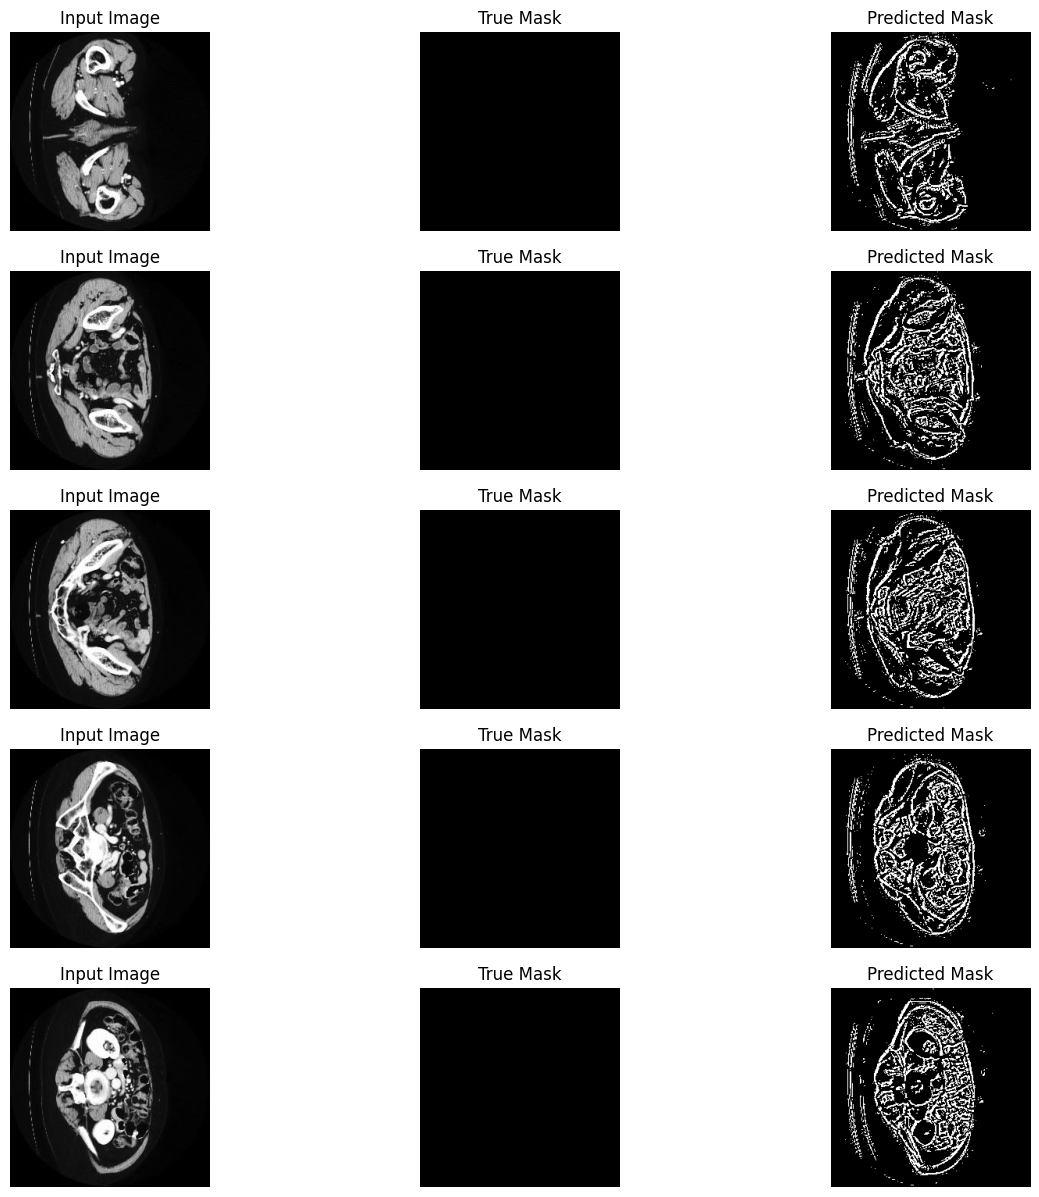

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


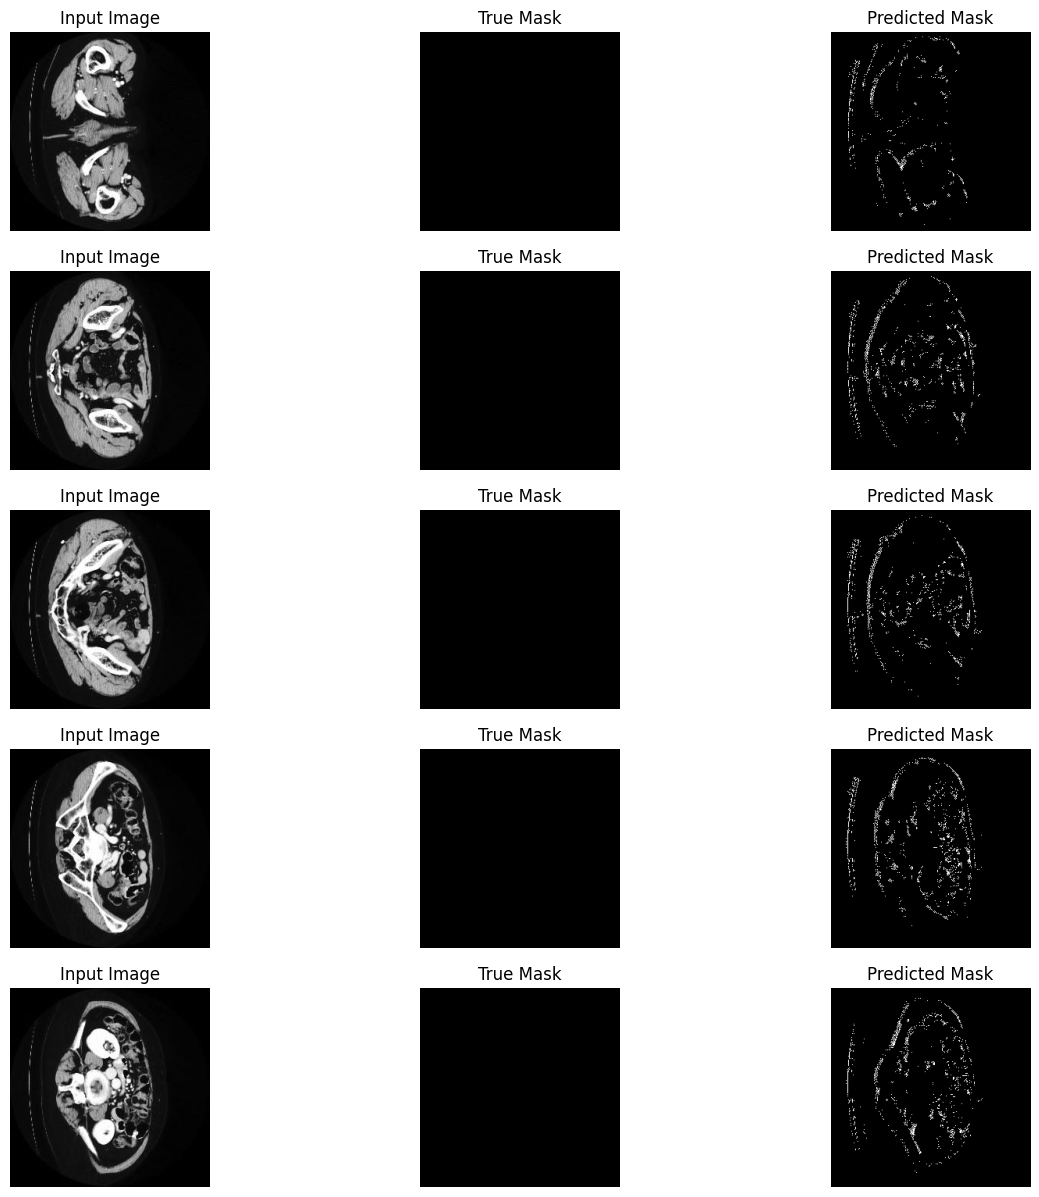

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, image_paths, mask_paths, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]

        # Load and preprocess images
        image = preprocess_image(image_path)
        true_mask = preprocess_image(mask_path)

        # Predict mask
        pred_mask = (model.predict(np.expand_dims(image, axis=0)) > 0.5).astype(np.uint8).squeeze()

        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask.squeeze(), cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.show()

# Directory paths
val_frames_dir = "/content/dataset/val_frames/val_frames"
val_masks_dir = "/content/dataset/val_masks/val_masks"

# Get file paths
val_image_paths = sorted(glob.glob(os.path.join(val_frames_dir, '*.jpg')))
val_mask_paths = sorted(glob.glob(os.path.join(val_masks_dir, '*.jpg')))

# Ensure that the number of images and masks is the same
assert len(val_image_paths) == len(val_mask_paths), "Mismatch between number of images and masks"

# Visualize predictions
visualize_predictions(unet_model, val_image_paths, val_mask_paths)
visualize_predictions(unet_pp_model, val_image_paths, val_mask_paths)


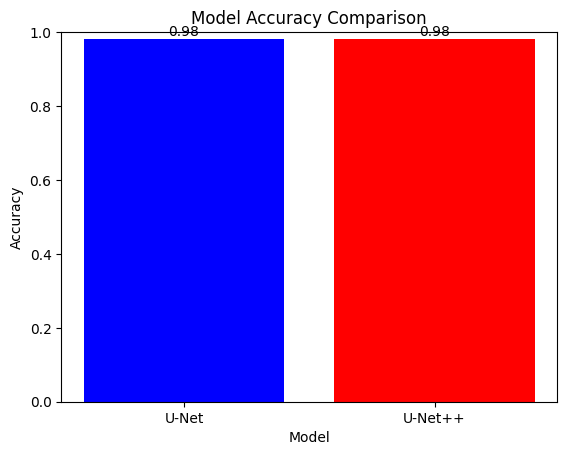

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values based on your results
accuracies = [0.9812, 0.9812]
labels = ['U-Net', 'U-Net++']

def plot_accuracy_comparison(accuracies, labels, title="Model Accuracy Comparison"):
    fig, ax = plt.subplots()
    bars = ax.bar(labels, accuracies, color=['blue', 'red'])

    # Add labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.ylim(0, 1)  # Set y-axis limit to make the bar heights more visible
    plt.show()

# Plot comparison
plot_accuracy_comparison(accuracies, labels)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the dataset
import zipfile
import os
zip_file_path = "/content/drive/MyDrive/Lits_dataset_Haritha.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [3]:
# Specify the root file path
directory_path = "/content/dataset"

In [4]:
# Display the folder structure
for root, dirs, files in os.walk(directory_path):
    print(root, "contains", len(files), "files")

/content/dataset contains 0 files
/content/dataset/val_frames contains 0 files
/content/dataset/val_frames/val_frames contains 8796 files
/content/dataset/train_frames contains 0 files
/content/dataset/train_frames/train_frames contains 49842 files
/content/dataset/train_masks contains 0 files
/content/dataset/train_masks/train_masks contains 49842 files
/content/dataset/val_masks contains 0 files
/content/dataset/val_masks/val_masks contains 8796 files


In [5]:
import numpy as np
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

IMG_WIDTH = 256
IMG_HEIGHT = 256

# Directory paths
train_frames_dir = "/content/dataset/train_frames/train_frames"
train_masks_dir = "/content/dataset/train_masks/train_masks"
val_frames_dir = "/content/dataset/val_frames/val_frames"
val_masks_dir = "/content/dataset/val_masks/val_masks"

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(256, 256), augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indexes]
        batch_mask_paths = [self.mask_paths[k] for k in batch_indexes]

        images, masks = self.__data_generation(batch_image_paths, batch_mask_paths)
        return images, masks

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
      images = np.empty((self.batch_size, *self.image_size, 1))
      masks = np.empty((self.batch_size, *self.image_size, 1))

      for i, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        image = cv2.resize(image, self.image_size)
        image = image / 255.0  # Normalization

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        mask = cv2.resize(mask, self.image_size)
        mask = mask / 255.0  # Normalization
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images[i,] = np.expand_dims(image, axis=-1)  # Add channel dimension

      return images, masks

In [6]:
# Paths to your image and mask directories
train_image_paths = sorted(glob.glob(os.path.join(train_frames_dir, "*.jpg")))
train_mask_paths = sorted(glob.glob(os.path.join(train_masks_dir, "*.jpg")))
val_image_paths = sorted(glob.glob(os.path.join(val_frames_dir, "*.jpg")))
val_mask_paths = sorted(glob.glob(os.path.join(val_masks_dir, "*.jpg")))

In [7]:
# Create data generators
train_generator = DataGenerator(train_image_paths, train_mask_paths, batch_size=4)
val_generator = DataGenerator(val_image_paths, val_mask_paths, batch_size=4)

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Dropout
from tensorflow.keras.models import Model

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.2)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Dropout(0.1)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [9]:
# Define your model
unet_model = unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 512)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import glob
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming IMG_HEIGHT and IMG_WIDTH are defined
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 4

# Define paths to your images and masks (replace these with the actual paths)
val_frames_dir = "/content/dataset/val_frames/val_frames"
val_masks_dir = "/content/dataset/val_masks/val_masks"

val_image_paths = sorted(glob.glob(os.path.join(val_frames_dir, "*.jpg")))
val_mask_paths = sorted(glob.glob(os.path.join(val_masks_dir, "*.jpg")))
# Data loading function (defined earlier)
def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = mask / 255.0  # Normalize

    return image, mask

# Dataset creation
def load_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create validation dataset
val_dataset = load_dataset(val_image_paths, val_mask_paths, batch_size=BATCH_SIZE)


In [13]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf

def compute_metrics(y_true, y_pred):
    if tf.executing_eagerly():
        y_true = y_true.numpy()
    else:
        y_true = np.array(y_true)

    y_true = y_true.flatten()

    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()

    y_pred = y_pred.flatten()

    # Ensure predictions are binary
    y_pred = (y_pred > 0.5).astype(np.int32)
    y_true_binary = (y_true > 0.5).astype(np.int32)

    # Calculate metrics with zero_division to handle cases where there are no positive samples
    precision = precision_score(y_true_binary, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true_binary, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true_binary, y_pred, average='binary', zero_division=1)
    accuracy = accuracy_score(y_true_binary, y_pred)

    return precision, recall, f1, accuracy

# Initialize accumulators for evaluation metrics
total_precision, total_recall, total_f1, total_accuracy = 0, 0, 0, 0
num_batches = 0

# Loop over validation dataset batch by batch
for image_batch, mask_batch in val_dataset:
    # Simulate model predictions for this batch
    predicted_batch = unet_model.predict(image_batch)  # Replace with actual predictions

    # Compute metrics for this batch
    precision, recall, f1, accuracy = compute_metrics(mask_batch, predicted_batch)

    # Accumulate metrics
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_accuracy += accuracy
    num_batches += 1

# Calculate average metrics across all batches
avg_precision = total_precision / num_batches
avg_recall = total_recall / num_batches
avg_f1 = total_f1 / num_batches
avg_accuracy = total_accuracy / num_batches

# Print results
print(f"Average Recall: {avg_recall}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [15]:
def compute_metrics(y_true, y_pred, threshold=0.5):
    if tf.executing_eagerly():
        y_true = y_true.numpy()
    else:
        y_true = np.array(y_true)

    y_true = y_true.flatten()

    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()

    y_pred = y_pred.flatten()

    # Adjust threshold
    y_pred = (y_pred > threshold).astype(np.int32)
    y_true_binary = (y_true > 0.5).astype(np.int32)

    # Calculate metrics with zero_division to handle cases where there are no positive samples
    precision = precision_score(y_true_binary, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true_binary, y_pred, average='binary', zero_division=1)


    return precision, f1

# Test different thresholds
for threshold in np.arange(0.6, 1.0, 0.1):
    precision, f1 = compute_metrics(mask_batch, predicted_batch, threshold)
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, F1 Score: {f1:.2f}")

Threshold: 0.6, Precision: 1.00, F1 Score: 1.00
Threshold: 0.7, Precision: 1.00, F1 Score: 1.00
Threshold: 0.8, Precision: 1.00, F1 Score: 1.00
Threshold: 0.9, Precision: 1.00, F1 Score: 1.00


In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model

def unet_plus_plus(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Dropout(0.2)(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Dropout(0.2)(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Dropout(0.1)(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Dropout(0.1)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [17]:
# compile
unet_pp_model = unet_plus_plus()
unet_pp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_pp_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 256)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 16, 16, 512)    │              0 │ max_pooling2d_7[0][0]  │
├──────────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf

def compute_metrics(y_true, y_pred):
    if tf.executing_eagerly():
        y_true = y_true.numpy()
    else:
        y_true = np.array(y_true)

    y_true = y_true.flatten()

    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()

    y_pred = y_pred.flatten()

    # Ensure predictions are binary
    y_pred = (y_pred > 0.5).astype(np.int32)
    y_true_binary = (y_true > 0.5).astype(np.int32)

    # Calculate metrics with zero_division to handle cases where there are no positive samples
    precision = precision_score(y_true_binary, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true_binary, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true_binary, y_pred, average='binary', zero_division=1)
    accuracy = accuracy_score(y_true_binary, y_pred)

    return precision, recall, f1, accuracy

# Initialize accumulators for evaluation metrics
total_precision, total_recall, total_f1, total_accuracy = 0, 0, 0, 0
num_batches = 0

# Loop over validation dataset batch by batch
for image_batch, mask_batch in val_dataset:
    # Simulate model predictions for this batch
    predicted_batch = unet_pp_model.predict(image_batch)  # Replace with actual predictions

    # Compute metrics for this batch
    precision, recall, f1, accuracy = compute_metrics(mask_batch, predicted_batch)

    # Accumulate metrics
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    total_accuracy += accuracy
    num_batches += 1

# Calculate average metrics across all batches
avg_precision = total_precision / num_batches
avg_recall = total_recall / num_batches
avg_f1 = total_f1 / num_batches
avg_accuracy = total_accuracy / num_batches

# Print results
print(f"Average Recall: {avg_recall}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [20]:
def compute_metrics(y_true, y_pred, threshold=0.5):
    if tf.executing_eagerly():
        y_true = y_true.numpy()
    else:
        y_true = np.array(y_true)

    y_true = y_true.flatten()

    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()

    y_pred = y_pred.flatten()

    # Adjust threshold
    y_pred = (y_pred > threshold).astype(np.int32)
    y_true_binary = (y_true > 0.5).astype(np.int32)

    # Calculate metrics with zero_division to handle cases where there are no positive samples
    precision = precision_score(y_true_binary, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true_binary, y_pred, average='binary', zero_division=1)


    return precision, f1

# Test different thresholds
for threshold in np.arange(0.6, 1.0, 0.1):
    precision, f1 = compute_metrics(mask_batch, predicted_batch, threshold)
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, F1 Score: {f1:.2f}")

Threshold: 0.6, Precision: 1.00, F1 Score: 1.00
Threshold: 0.7, Precision: 1.00, F1 Score: 1.00
Threshold: 0.8, Precision: 1.00, F1 Score: 1.00
Threshold: 0.9, Precision: 1.00, F1 Score: 1.00
